This notebook takes the combined run- and experiment-wide metrics of each sequence-charge, and builds a run-specific estimator for intensity delta.

X is a sequence's attributes in a run:
- log2 intensity
- uncalibrated m/z (the raw intensity as extracted by TFD)
- charge
- retention time
- CCS

y is the delta of intensity in a run from the median intensity of the sequence over the experiment.

For training, filter:
- human only
- only sequences detected in at least half the runs
- only 1to1 runs

In [1]:
import pandas as pd
import numpy as np
import sys
import pickle
import glob
import os
import matplotlib.pyplot as plt

In [2]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV,ShuffleSplit,RandomizedSearchCV

In [3]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

In [4]:
# produced by the notebook "classify all features extracted from all the runs"
SEQUENCES_WITH_SPECIES_FILE_NAME = '/Users/darylwilding-mcbride/Downloads/sequences-with-species-df.pkl'
# copied from BAM
MAPPING_FILE_NAME = "/Users/darylwilding-mcbride/Downloads/experiments/dwm-test/recalibrated-percolator-output/percolator-idx-mapping.csv"

In [5]:
# determine the mapping between the percolator index and the run file name
def get_percolator_run_mapping(mapping_file_name):
    df = pd.read_csv(mapping_file_name)
    mapping_l = [tuple(r) for r in df.to_numpy()]
    return mapping_l

In [6]:
def file_idx_for_run(run_name):
    result = None
    mapping_l = get_percolator_run_mapping(MAPPING_FILE_NAME)
    for m in mapping_l:
        if m[1] == run_name:
            result = m[0]
            break
    return result

def run_name_for_file_idx(file_idx):
    result = None
    mapping_l = get_percolator_run_mapping(MAPPING_FILE_NAME)
    for m in mapping_l:
        if m[0] == file_idx:
            result = m[1]
            break
    return result


In [7]:
sequences_with_species_df = pd.read_pickle(SEQUENCES_WITH_SPECIES_FILE_NAME)

In [8]:
sequences_with_species_df.columns

Index(['sequence', 'charge', 'file_idx', 'intensity', 'classed_as', 'run_name',
       'batch', 'human'],
      dtype='object')

In [9]:
sequences_with_species_df.isnull().sum()

sequence      0
charge        0
file_idx      0
intensity     0
classed_as    0
run_name      0
batch         0
human         0
dtype: int64

In [10]:
TARGET_DECOY_MODEL_DIR = '/Users/darylwilding-mcbride/Downloads/experiments/dwm-test/target-decoy-models'
EXPERIMENT_METRICS_FILE_NAME = "{}/experiment-metrics-for-library-sequences.pkl".format(TARGET_DECOY_MODEL_DIR)

In [11]:
experiment_metrics_for_library_sequences_df = pd.read_pickle(EXPERIMENT_METRICS_FILE_NAME)

In [12]:
experiment_metrics_for_library_sequences_df.columns

Index(['sequence', 'charge', 'theoretical_mz', 'experiment_scan_mean',
       'experiment_scan_std_dev', 'experiment_scan_peak_width',
       'experiment_rt_mean', 'experiment_rt_std_dev',
       'experiment_rt_peak_width', 'experiment_intensity_mean',
       'experiment_intensity_std_dev', 'number_of_runs_identified', 'q_value',
       'file_idx', 'target_coords', 'decoy_coords', 'target_metrics',
       'attributes', 'decoy_metrics'],
      dtype='object')

In [13]:
experiment_metrics_for_library_sequences_df.isnull().sum()

sequence                           0
charge                             0
theoretical_mz                     0
experiment_scan_mean               0
experiment_scan_std_dev            0
experiment_scan_peak_width         0
experiment_rt_mean                 0
experiment_rt_std_dev              0
experiment_rt_peak_width           0
experiment_intensity_mean          0
experiment_intensity_std_dev       0
number_of_runs_identified          0
q_value                            0
file_idx                           0
target_coords                      0
decoy_coords                       0
target_metrics                  1157
attributes                         0
decoy_metrics                   6577
dtype: int64

#### Merge the unpacked attributes of the TFD-extracted sequence (in experiment_metrics_for_library_sequences_df) with the sequences_with_species_df

In [14]:
# unpack the TFD-extracted attributes from each sequence
attributes = []
attribute_names = [key for key in sorted(experiment_metrics_for_library_sequences_df.iloc[0].attributes)]

for row in experiment_metrics_for_library_sequences_df.itertuples():
    # target metric values
    d = row.attributes
    if (d is not None) and all(d.values()):
        l = []
        l.append(row.sequence)
        l.append(row.charge)
        l.append(row.file_idx)
        l += [d[key] for key in sorted(d)]
        attributes.append(tuple(l))

columns = ['sequence','charge','file_idx']
columns += attribute_names

attributes_as_extracted_df = pd.DataFrame(attributes, columns=columns)

In [15]:
attributes_as_extracted_df.isnull().sum()

sequence                         0
charge                           0
file_idx                         0
intensity_all_points             0
intensity_saturation_adjusted    0
intensity_top_3                  0
monoisotopic_mz                  0
rt_apex                          0
scan_apex                        0
dtype: int64

In [16]:
len(attributes_as_extracted_df)

586544

In [17]:
attributes_as_extracted_df.intensity_top_3.max(), attributes_as_extracted_df.intensity_top_3.min()

(51913, 9)

In [18]:
attributes_as_extracted_df.head()

,sequence,charge,file_idx,intensity_all_points,intensity_saturation_adjusted,intensity_top_3,monoisotopic_mz,rt_apex,scan_apex
0,AAAAAAAAAAAAAAAASAGGK,2,0,1956,170299,331,778.415635,937.100303,533.000000
1,AAAAAAAAAPAAAATAPTTAATTAATAAQ,2,0,321139,376227,6502,1184.609205,594.503517,70.440081
2,AAAAAAAAVPSAGPAGPAPTSAAGR,2,0,3014,10099,328,1016.532371,486.625154,152.472187
3,AAAAATVVPPMVGGPPFVGPVGFGPGDR,3,0,8014,23001,336,864.452576,1034.987311,708.747001
4,AAAAAWEEPSSGNGTAR,2,0,76396,114563,1762,823.382040,367.242494,538.177052


In [19]:
len(sequences_with_species_df)

543846

In [20]:
len(attributes_as_extracted_df)

586544

In [21]:
sequences_with_attributes_df = pd.merge(attributes_as_extracted_df, sequences_with_species_df, how='inner', left_on=['sequence','charge','file_idx'], right_on=['sequence','charge','file_idx'])
sequences_with_attributes_df['log_intensity'] = np.log2(sequences_with_attributes_df.intensity_saturation_adjusted)

In [22]:
sequences_with_attributes_df.columns

Index(['sequence', 'charge', 'file_idx', 'intensity_all_points',
       'intensity_saturation_adjusted', 'intensity_top_3', 'monoisotopic_mz',
       'rt_apex', 'scan_apex', 'intensity', 'classed_as', 'run_name', 'batch',
       'human', 'log_intensity'],
      dtype='object')

In [23]:
len(sequences_with_attributes_df)

542281

In [24]:
# find the experiment-wide means and std devs
experiment_intensities_l = []
for group_name,group_df in sequences_with_attributes_df.groupby(['sequence','charge'], as_index=False):
    number_of_runs_for_sequence = len(group_df)
    # intensity
    experiment_intensity_mean = np.mean(group_df.log_intensity)
    experiment_intensity_std_dev = np.std(group_df.log_intensity)
    # rt
    experiment_rt_mean = np.mean(group_df.rt_apex)
    experiment_rt_std_dev = np.std(group_df.rt_apex)
    # scan
    experiment_scan_mean = np.mean(group_df.scan_apex)
    experiment_scan_std_dev = np.std(group_df.scan_apex)
    # sequence and charge
    sequence = group_name[0]
    charge = group_name[1]
    experiment_intensities_l.append((sequence,charge,experiment_intensity_mean,experiment_intensity_std_dev,experiment_rt_mean,experiment_rt_std_dev,experiment_scan_mean,experiment_scan_std_dev,number_of_runs_for_sequence))

experiment_intensities_df = pd.DataFrame(experiment_intensities_l, columns=['sequence','charge','experiment_intensity_mean','experiment_intensity_std_dev','experiment_rt_mean','experiment_rt_std_dev','experiment_scan_mean','experiment_scan_std_dev','number_of_runs_for_sequence'])


In [25]:
experiment_intensities_df.sample(10)

,sequence,charge,experiment_intensity_mean,experiment_intensity_std_dev,experiment_rt_mean,experiment_rt_std_dev,experiment_scan_mean,experiment_scan_std_dev,number_of_runs_for_sequence
26633,VAIHEAMEQQTISIAK,2,16.367944,0.139445,542.436692,3.648701,326.360139,4.083616,19
21039,QSFTMVADTPENLR,2,16.937583,0.651051,640.315249,3.485285,509.451660,16.662374,20
20905,QPWVASATPAVSQNLR,2,13.522961,0.818676,1086.298909,4.649635,396.790045,10.464030,17
8271,FLYPLTIPDAQFDAAMK,2,16.783353,1.205120,1040.161104,4.380913,236.307797,7.874276,20
11990,HTTDHPMQCILTR,2,16.897179,0.476602,377.204113,5.448321,469.064999,32.841612,19
20252,QATDNSEISSATK,2,16.528015,0.381526,232.485181,3.661978,679.894166,5.327665,20
5951,EGSTQQLQTTSPK,2,17.169842,1.103337,242.396530,3.209288,623.081265,2.944008,20
8311,FM[15.9949]VDIACGMEYLSSR,2,16.443703,0.115218,599.007598,5.653214,359.858228,11.384416,20
21396,Q[-17.0265]DHAQQLATAAEER,2,16.495688,0.294250,404.691725,1.843281,554.450949,3.632802,20
6268,ELAQQVQQVADDYGK,2,17.746434,0.507575,618.402252,2.215900,437.360522,3.369852,20


In [26]:
sequences_df = pd.merge(sequences_with_attributes_df, experiment_intensities_df, how='left', left_on=['sequence','charge'], right_on=['sequence','charge'])

In [27]:
sequences_df.columns

Index(['sequence', 'charge', 'file_idx', 'intensity_all_points',
       'intensity_saturation_adjusted', 'intensity_top_3', 'monoisotopic_mz',
       'rt_apex', 'scan_apex', 'intensity', 'classed_as', 'run_name', 'batch',
       'human', 'log_intensity', 'experiment_intensity_mean',
       'experiment_intensity_std_dev', 'experiment_rt_mean',
       'experiment_rt_std_dev', 'experiment_scan_mean',
       'experiment_scan_std_dev', 'number_of_runs_for_sequence'],
      dtype='object')

#### Note that from now on we work with intensity and intensity delta in log2 space. The median is the median of log2(intensity).

In [28]:
sequences_df['delta_intensity'] = (sequences_df.log_intensity - sequences_df.experiment_intensity_mean) / sequences_df.experiment_intensity_mean


In [29]:
file_idx = 2
run_name = run_name_for_file_idx(file_idx)
run_name

'190719_Hela_Ecoli_1to1_09'

In [30]:
minimum_number_of_runs_for_training_set = 10

In [31]:
# make the training set from human only, comprising sequences we have identified in a minimum of runs
training_set_all_runs_df = sequences_df[(sequences_df.human == True) & (sequences_df.number_of_runs_for_sequence > minimum_number_of_runs_for_training_set)].copy()
training_set_selected_run_df = training_set_all_runs_df[training_set_all_runs_df.file_idx == file_idx]


In [94]:
print("training set is {}% of the complete sequence set".format(round(len(training_set_all_runs_df) / len(sequences_df) * 100, 1)))

training set is 78.5% of the complete sequence set


In [96]:
print("{}% of the sequences in this run are in the training set".format(round(len(training_set_selected_run_df) / len(sequences_df[sequences_df.file_idx == file_idx]) * 100, 1)))

77.0% of the sequences in this run are in the training set


In [32]:
training_set_selected_run_df.sample(5)

,sequence,charge,file_idx,intensity_all_points,intensity_saturation_adjusted,intensity_top_3,monoisotopic_mz,rt_apex,scan_apex,intensity,...,human,log_intensity,experiment_intensity_mean,experiment_intensity_std_dev,experiment_rt_mean,experiment_rt_std_dev,experiment_scan_mean,experiment_scan_std_dev,number_of_runs_for_sequence,delta_intensity
62071,GAVGALLVYDIAK,2,2,109078,167613,3011,645.376645,867.288571,590.809949,3011,...,True,17.354775,16.068199,1.302776,864.710346,4.640392,590.127215,1.954146,20,0.080070
67575,LESGM[15.9949]QNM[15.9949]SIHTK,2,2,2741,3601,280,754.348584,202.149451,553.872024,280,...,True,11.814182,13.070291,0.543782,205.071580,2.512328,556.121286,5.869437,19,-0.096104
78633,VNHVTLSQPK,2,2,63816,140944,4357,561.818195,252.880768,773.252004,4357,...,True,17.104763,17.591492,0.366895,254.065226,2.841733,777.909022,3.421205,20,-0.027668
62485,GGAEQFM[15.9949]EETER,2,2,1475,70913,263,700.292618,319.476996,662.433559,263,...,True,16.113763,16.782677,0.433257,314.246479,6.165170,663.545753,6.737799,20,-0.039857
61601,FQQQLEQLNAMGFLNR,2,2,131800,543056,4152,968.989039,883.077260,258.492612,4152,...,True,19.050741,18.807074,0.435490,881.382062,3.588882,255.437908,4.168930,20,0.012956


In [33]:
len(training_set_selected_run_df)

21116

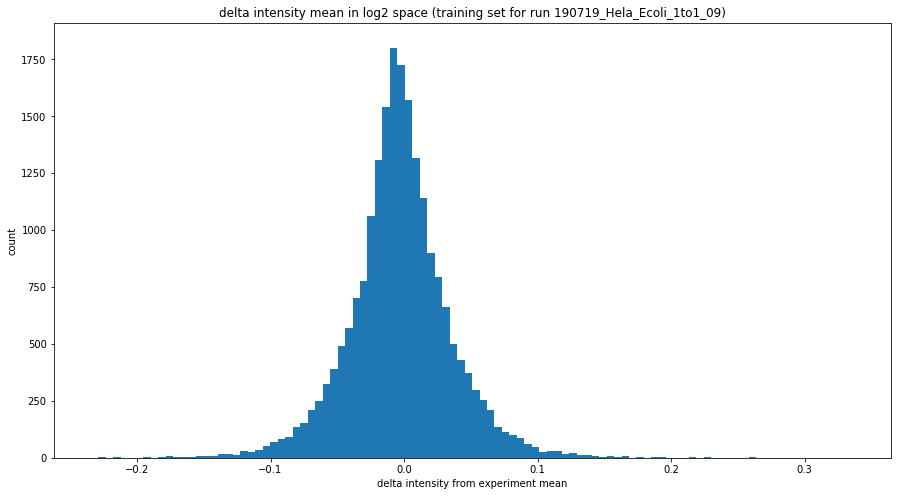

In [34]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)
plt.title('')

bins = 100
hist, bins, _ = plt.hist(training_set_selected_run_df.delta_intensity, bins=bins)
plt.xlabel('delta intensity from experiment mean')
plt.ylabel('count')
plt.title('delta intensity mean in log2 space (training set for run {})'.format(run_name))

plt.show()

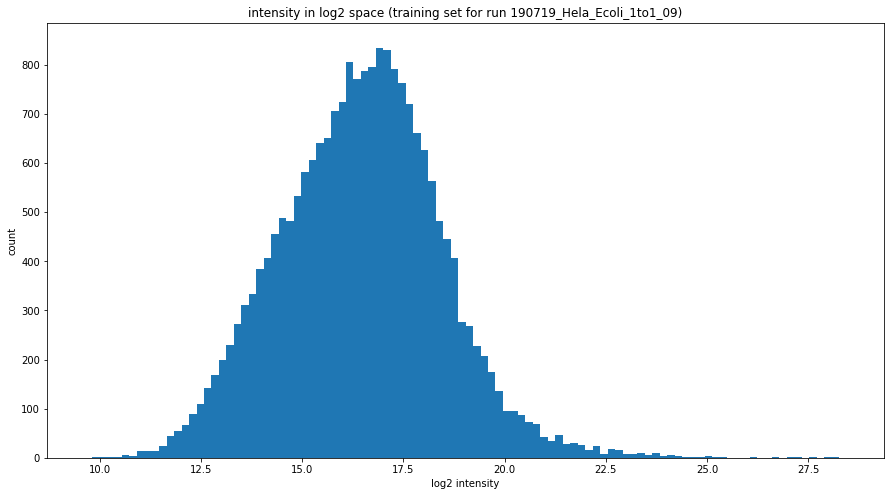

In [35]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)
plt.title('')

bins = 100
hist, bins, _ = plt.hist(training_set_selected_run_df.log_intensity, bins=bins)
plt.xlabel('log2 intensity')
plt.ylabel('count')
plt.title('intensity in log2 space (training set for run {})'.format(run_name))

plt.show()

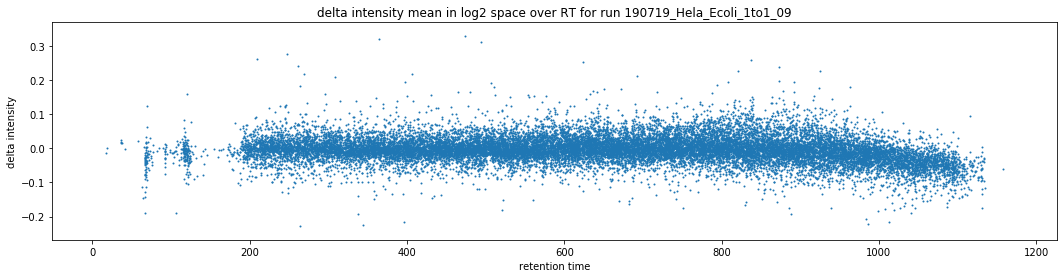

In [36]:
f, ax = plt.subplots()
f.set_figheight(4)
f.set_figwidth(18)

plt.margins(0.06)
plt.title('')

ax.scatter(training_set_selected_run_df.rt_apex, training_set_selected_run_df.delta_intensity, marker='o', lw=0, s=4, alpha=1.0)

# plt.legend(loc='best')
plt.ylabel('delta intensity')
plt.xlabel('retention time')
plt.title('delta intensity mean in log2 space over RT for run {}'.format(run_name))
# plt.xlim((300,400))
# plt.ylim((-2,2))

plt.show()

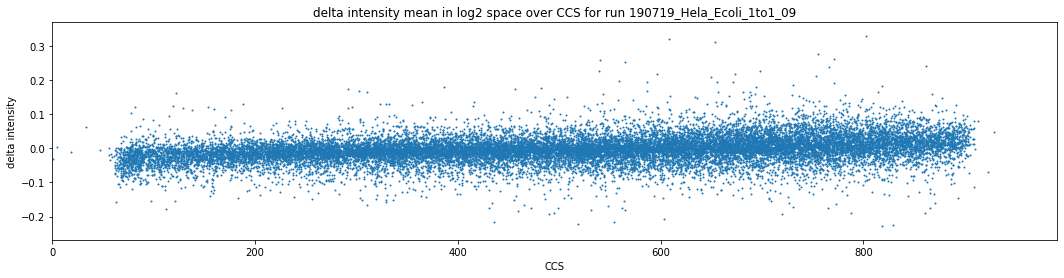

In [37]:
f, ax = plt.subplots()
f.set_figheight(4)
f.set_figwidth(18)

plt.margins(0.06)
plt.title('')

ax.scatter(training_set_selected_run_df.scan_apex, training_set_selected_run_df.delta_intensity, marker='o', lw=0, s=4, alpha=1.0)

# plt.legend(loc='best')
plt.ylabel('delta intensity')
plt.xlabel('CCS')
plt.title('delta intensity mean in log2 space over CCS for run {}'.format(run_name))
plt.xlim((0,991))
# plt.ylim((-2,2))

plt.show()

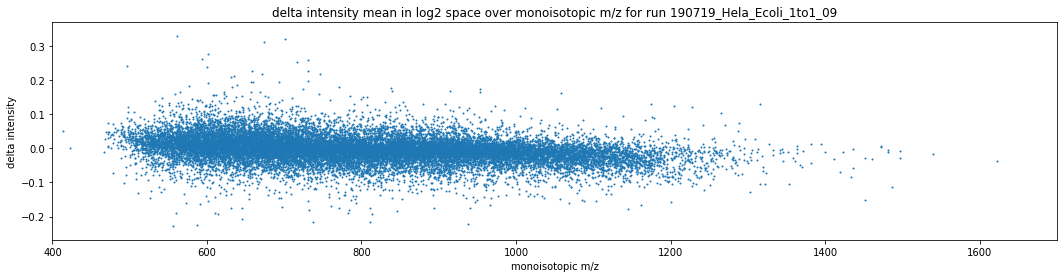

In [38]:
f, ax = plt.subplots()
f.set_figheight(4)
f.set_figwidth(18)

plt.margins(0.06)

ax.scatter(training_set_selected_run_df.monoisotopic_mz, training_set_selected_run_df.delta_intensity, marker='o', lw=0, s=4, alpha=1.0)

# plt.legend(loc='best')
plt.ylabel('delta intensity')
plt.xlabel('monoisotopic m/z')
plt.title('delta intensity mean in log2 space over monoisotopic m/z for run {}'.format(run_name))
plt.xlim((400,1700))
# plt.ylim((-3,3))

plt.show()

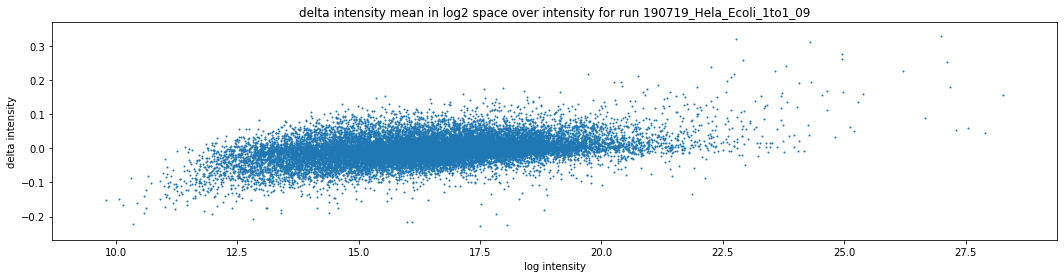

In [39]:
f, ax = plt.subplots()
f.set_figheight(4)
f.set_figwidth(18)

plt.margins(0.06)

ax.scatter(training_set_selected_run_df.log_intensity, training_set_selected_run_df.delta_intensity, marker='o', lw=0, s=4, alpha=1.0)

# plt.legend(loc='best')
plt.ylabel('delta intensity')
plt.xlabel('log intensity')
plt.title('delta intensity mean in log2 space over intensity for run {}'.format(run_name))
# plt.xlim((400,1700))

plt.show()

#### create a gradient boosted regressor model

In [40]:
def GradientBooster(param_grid, n_jobs, X_train, y_train):
    estimator = GradientBoostingRegressor()
    cv = ShuffleSplit(n_splits=10, train_size=0.8, test_size=0.2, random_state=0)
    classifier = RandomizedSearchCV(estimator=estimator, cv=cv, param_distributions=param_grid, n_jobs=n_jobs)
    classifier.fit(X_train, y_train)
    print('best estimator found: {}'.format(classifier.best_estimator_))
    return cv, classifier.best_estimator_


#### train a model for a selected run

In [41]:
training_set_selected_run_df.columns

Index(['sequence', 'charge', 'file_idx', 'intensity_all_points',
       'intensity_saturation_adjusted', 'intensity_top_3', 'monoisotopic_mz',
       'rt_apex', 'scan_apex', 'intensity', 'classed_as', 'run_name', 'batch',
       'human', 'log_intensity', 'experiment_intensity_mean',
       'experiment_intensity_std_dev', 'experiment_rt_mean',
       'experiment_rt_std_dev', 'experiment_scan_mean',
       'experiment_scan_std_dev', 'number_of_runs_for_sequence',
       'delta_intensity'],
      dtype='object')

In [42]:
training_attributes = ['log_intensity','experiment_intensity_mean','experiment_intensity_std_dev','experiment_rt_mean','experiment_rt_std_dev','experiment_scan_mean','experiment_scan_std_dev','charge']


In [43]:
training_set_selected_run_df[training_attributes].sample(10)

,log_intensity,experiment_intensity_mean,experiment_intensity_std_dev,experiment_rt_mean,experiment_rt_std_dev,experiment_scan_mean,experiment_scan_std_dev,charge
79306,16.854954,16.887664,0.474230,406.476734,2.662971,846.048126,7.938419,2
67878,17.965756,18.041390,0.242023,390.381088,5.623423,478.691273,6.447515,2
56245,17.381450,17.437368,0.150452,635.451669,4.636676,518.531777,2.591557,3
76641,15.703336,15.626429,0.248881,736.333490,3.109737,115.456715,6.744430,2
55049,17.373953,17.365587,0.507587,477.001495,6.381050,565.146754,2.878188,2
77812,13.103780,14.961327,1.040100,1044.527923,4.500549,433.820470,14.536124,3
75291,18.630086,18.755405,0.159725,890.471319,1.665810,364.427676,15.674342,2
55302,17.548423,18.177668,0.799787,432.319088,2.484750,721.152712,10.413514,2
54840,14.999339,15.604509,0.698397,1046.170529,5.099942,501.846158,101.207485,3
63076,16.341241,16.677018,0.439264,419.094620,3.509050,554.259652,3.029005,2


In [44]:
# split the training set
X = training_set_selected_run_df[training_attributes].values
y = training_set_selected_run_df[['delta_intensity']].values[:,0]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

In [45]:
len(X_train), len(X_test)

(19004, 2112)

In [46]:
# create the model we will use
params = {'n_estimators': 1000, 'learning_rate': 0.1, 'max_depth': 6, 'min_samples_leaf': 5, 'max_features': 1.0, 'loss':'huber'}
best_estimator = GradientBoostingRegressor(**params)


In [47]:
# train the model
best_estimator.fit(X_train, y_train)
train_score = best_estimator.score(X_train, y_train)
test_score = best_estimator.score(X_test, y_test)
print("R-squared for training set: {}, test set: {}".format(round(train_score,1), round(test_score, 1)))

R-squared for training set: 1.0, test set: 1.0


#### Plot the intensity error

In [48]:
feature_names = np.array(training_attributes)

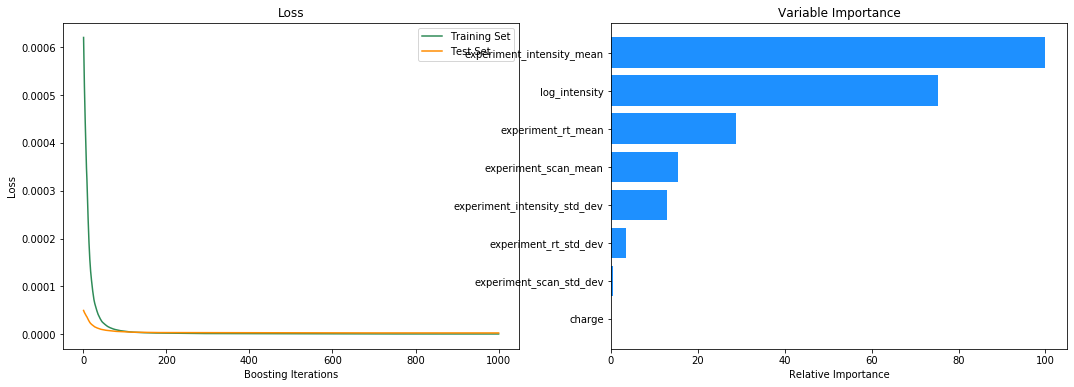

In [49]:
# Plot training loss

# compute test set deviance
test_score = np.zeros((params['n_estimators'],), dtype=np.float64)

for i, y_pred in enumerate(best_estimator.staged_predict(X_test)):
    test_score[i] = best_estimator.loss_(y_test, y_pred)

plt.figure(figsize=(18, 6))
plt.margins(0.06)
plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(np.arange(params['n_estimators']) + 1, best_estimator.train_score_, 'seagreen', label='Training Set')
plt.plot(np.arange(params['n_estimators']) + 1, test_score, 'darkorange', label='Test Set')
plt.legend(loc='best')
plt.xlabel('Boosting Iterations')
plt.ylabel('Loss')

# Plot feature importance
feature_importance = best_estimator.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center', color='dodgerblue')
plt.yticks(pos, feature_names[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')

plt.show()

In [50]:
# use the trained model to predict the intensity delta for the test set
y_test_predicted = best_estimator.predict(X_test)

#### train a model for each of the runs

In [51]:
mapping_l = get_percolator_run_mapping(MAPPING_FILE_NAME)

In [52]:
for mapping in mapping_l:
    file_idx_for_this_model = mapping[0]
    
    # filter out rows we don't want in the training set for this run-specific model
    training_set_for_run_df = training_set_all_runs_df[(training_set_all_runs_df.file_idx == file_idx_for_this_model)]
    print("there are {} sequences in the training set for file {}".format(len(training_set_for_run_df), file_idx_for_this_model))

    # split the training set
    X = training_set_for_run_df[training_attributes].values
    y = training_set_for_run_df[['delta_intensity']].values[:,0]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

    # train the model
    best_estimator.fit(X_train, y_train)
    train_score = best_estimator.score(X_train, y_train)
    test_score = best_estimator.score(X_test, y_test)
    print("R-squared for training set: {}, test set: {}".format(round(train_score,1), round(test_score, 1)))

    # save the trained model
    MODEL_FILE_NAME = '/Users/darylwilding-mcbride/Downloads/experiments/dwm-test/intensity-models/file-{}-intensity-model.pkl'.format(file_idx_for_this_model)
    with open(MODEL_FILE_NAME, 'wb') as file:
        pickle.dump(best_estimator, file)

there are 21187 sequences in the training set for file 0
R-squared for training set: 1.0, test set: 1.0
there are 21364 sequences in the training set for file 1
R-squared for training set: 1.0, test set: 1.0
there are 21116 sequences in the training set for file 2
R-squared for training set: 1.0, test set: 1.0
there are 21121 sequences in the training set for file 3
R-squared for training set: 1.0, test set: 1.0
there are 21167 sequences in the training set for file 4
R-squared for training set: 1.0, test set: 1.0
there are 21467 sequences in the training set for file 5
R-squared for training set: 1.0, test set: 1.0
there are 21849 sequences in the training set for file 6
R-squared for training set: 1.0, test set: 1.0
there are 21142 sequences in the training set for file 7
R-squared for training set: 1.0, test set: 1.0
there are 20820 sequences in the training set for file 8
R-squared for training set: 1.0, test set: 1.0
there are 21230 sequences in the training set for file 9
R-squar

#### use the run-specific models to estimate the intensity for all sequences in all runs

In [53]:
sequences_df.columns

Index(['sequence', 'charge', 'file_idx', 'intensity_all_points',
       'intensity_saturation_adjusted', 'intensity_top_3', 'monoisotopic_mz',
       'rt_apex', 'scan_apex', 'intensity', 'classed_as', 'run_name', 'batch',
       'human', 'log_intensity', 'experiment_intensity_mean',
       'experiment_intensity_std_dev', 'experiment_rt_mean',
       'experiment_rt_std_dev', 'experiment_scan_mean',
       'experiment_scan_std_dev', 'number_of_runs_for_sequence',
       'delta_intensity'],
      dtype='object')

In [77]:
sequences_l = []
for mapping in mapping_l:
    file_idx = mapping[0]
    
    # load the model for this run
    MODEL_FILE_NAME = '/Users/darylwilding-mcbride/Downloads/experiments/dwm-test/intensity-models/file-{}-intensity-model.pkl'.format(file_idx)
    with open(MODEL_FILE_NAME, 'rb') as file:
        estimator = pickle.load(file)
    
    # get the sequences in this run
    df = sequences_df[sequences_df.file_idx == file_idx].copy()
    
    # build the list of sequences for inference
    X = df[training_attributes].values

    # predict the log2 delta intensity
    y = estimator.predict(X)
    
    df['estimated_delta_intensity'] = y
    df['normalised_intensity_log'] = (y * df.experiment_intensity_mean) + df.experiment_intensity_mean
    df['normalised_intensity_normal'] = np.power(2, df.normalised_intensity_log)
    
    sequences_l.append(df)

sequences_df = pd.concat(sequences_l, axis=0, sort=False)

In [89]:
sequences_df[['sequence','charge','experiment_intensity_mean','delta_intensity','estimated_delta_intensity','normalised_intensity_log']].sample(5)

,sequence,charge,experiment_intensity_mean,delta_intensity,estimated_delta_intensity,normalised_intensity_log
162619,YMNSGPVVAMVWEGLNVVK,2,14.963634,0.010078,0.007452,15.075141
285202,LLLLDTQQEAGMLLR,2,17.310392,0.000227,-0.000203,17.306884
463154,DHDEFIINLIR,2,15.418796,0.026050,0.024784,15.800942
82519,AQYEDIANR,2,16.364940,-0.051922,-0.052447,15.506652
237781,SHDDGNIDLESDSFLK,2,15.944658,0.013579,0.013204,16.155184


In [78]:
sequences_with_species_df.to_pickle('/Users/darylwilding-mcbride/Downloads/sequences-df.pkl')
sequences_with_species_df.to_csv('/Users/darylwilding-mcbride/Downloads/sequences-df.csv', index=False)


In [79]:
# for each sequence and charge, if it was found in more than 5 of the 1to1 and 5 of the 1to3 runs, 
# find the mean intensity in each batch, then find the intensity ratio between batches
sequence_occurences_in_batch = []
for group_name,group_df in sequences_df.groupby(['sequence','charge'], as_index=False):
    sequence_in_1to1_df = group_df[group_df.batch == '1to1']
    sequence_in_1to3_df = group_df[group_df.batch == '1to3']
    if (len(sequence_in_1to1_df) >= 5) and (len(sequence_in_1to3_df) >= 5):
        average_intensity_in_1to1 = np.mean(sequence_in_1to1_df.normalised_intensity_log)
        average_intensity_in_1to3 = np.mean(sequence_in_1to3_df.normalised_intensity_log)
        human = group_df.iloc[0].human
        sequence = group_name[0]
        charge = group_name[1]
        sequence_occurences_in_batch.append((sequence, charge, average_intensity_in_1to1, average_intensity_in_1to3, human))
        
sequence_occurences_in_batch_df = pd.DataFrame(sequence_occurences_in_batch, columns=['sequence','charge','intensity_1to1','intensity_1to3','human'])

In [80]:
sequence_occurences_in_batch_df['intensity_ratio'] = sequence_occurences_in_batch_df.intensity_1to3 / sequence_occurences_in_batch_df.intensity_1to1

In [81]:
human_df = sequence_occurences_in_batch_df[sequence_occurences_in_batch_df.human == True]
ecoli_df = sequence_occurences_in_batch_df[sequence_occurences_in_batch_df.human == False]

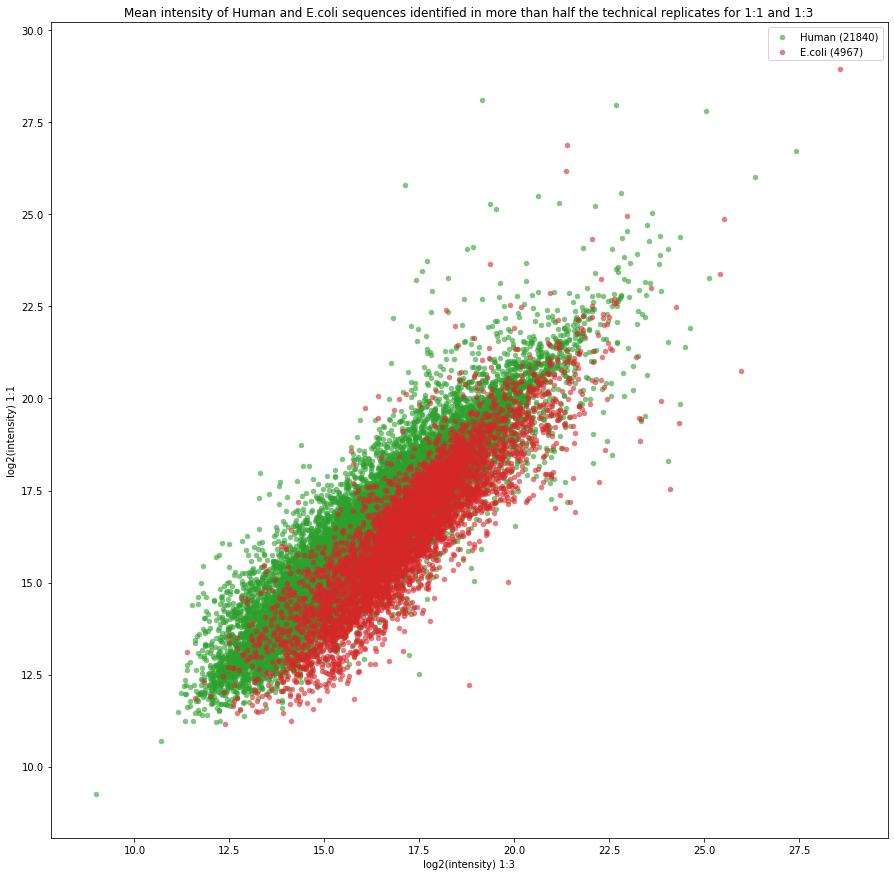

In [82]:
# For each sequence-charge identified in more than 5 runs in 1to1 and more than 5 runs in 1to3, take the average intensity in 
# each batch and plot their intensity. We should expect to see a shift in the E.coli sequences because they are 3 
# times more concentrated in the 1:3 batch.
f, ax = plt.subplots()
f.set_figheight(15)
f.set_figwidth(15)
plt.margins(0.06)

title = 'Mean intensity of Human and E.coli sequences identified in more than half the technical replicates for 1:1 and 1:3'
plt.title(title)

ax.scatter(human_df.intensity_1to3, human_df.intensity_1to1, marker='o', color='tab:green', lw=0, s=30, alpha=0.6, label="Human ({})".format(len(human_df)))
ax.scatter(ecoli_df.intensity_1to3, ecoli_df.intensity_1to1, marker='o', color='tab:red', lw=0, s=30, alpha=0.6, label="E.coli ({})".format(len(ecoli_df)))

plt.legend(loc='best')
plt.xlabel('log2(intensity) 1:3')
plt.ylabel('log2(intensity) 1:1')

# plt.xlim((4,17))
# plt.ylim((4,17))

plt.show()

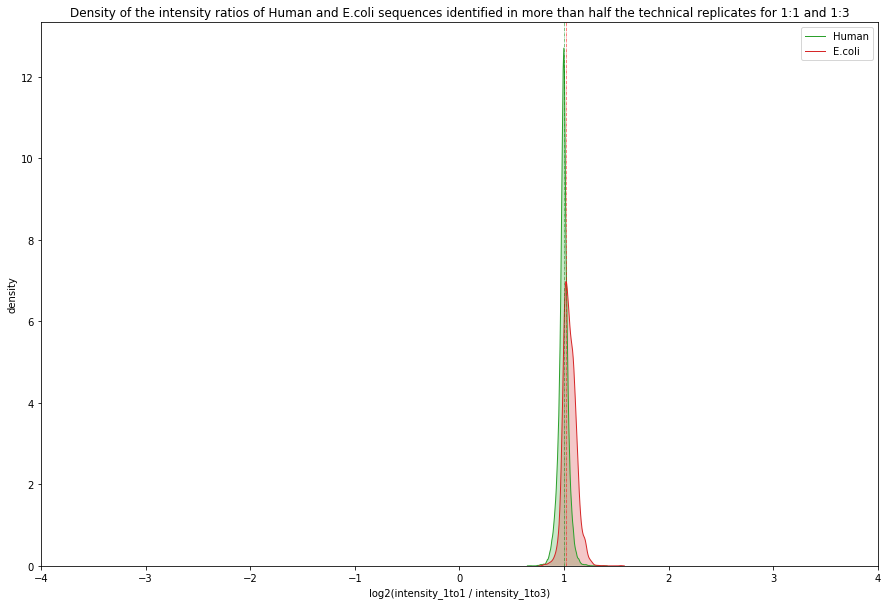

In [83]:
import seaborn as sns
plt.figure(figsize=(15, 10))

title = 'Density of the intensity ratios of Human and E.coli sequences identified in more than half the technical replicates for 1:1 and 1:3'
plt.title(title)

plt.xlim((-4,4))
# plt.ylim((0,1))

ax = sns.distplot(human_df['intensity_ratio'], hist = False, color='tab:green', kde = True, kde_kws = {'shade': True, 'linewidth': 1}, label = 'Human')
_ = sns.distplot(ecoli_df['intensity_ratio'], hist = False, color='tab:red', kde = True, kde_kws = {'shade': True, 'linewidth': 1}, label = 'E.coli')

x = ax.lines[0].get_xdata()
y = ax.lines[0].get_ydata()
plt.axvline(x[np.argmax(y)], color='green', lw=0.5, ls='-.')

x = ax.lines[1].get_xdata()
y = ax.lines[1].get_ydata()
plt.axvline(x[np.argmax(y)], color='red', lw=0.5, ls='-.')

_ = ax.set(xlabel='log2(intensity_1to1 / intensity_1to3)', ylabel='density')

#### plot the CVs before and after normalisation

In [84]:
sequence_cv_by_batch_l = []
for group_name,group_df in sequences_df.groupby(['sequence','charge','batch','human'], as_index=False):
    sequence = group_name[0]
    charge = group_name[1]
    batch = group_name[2]
    human = group_name[3]
    normalised_intensity_cv = np.std(group_df.normalised_intensity_normal) / np.mean(group_df.normalised_intensity_normal)
    sequence_cv_by_batch_l.append((sequence, charge, batch, human, normalised_intensity_cv))
sequence_cv_by_batch_df = pd.DataFrame(sequence_cv_by_batch_l, columns=['sequence','charge','batch','human','normalised_intensity_cv'])

In [62]:
sequence_cv_by_batch_df.head()

,sequence,charge,batch,human,normalised_intensity_cv
0,AAAAAAAAAAAAAAAASAGGK,2,1to1,True,0.100010
1,AAAAAAAAAAAAAAAASAGGK,2,1to3,True,0.256551
2,AAAAAAAAAPAAAATAPTTAATTAATAAQ,2,1to1,True,0.207019
3,AAAAAAAAAPAAAATAPTTAATTAATAAQ,2,1to3,True,0.265290
4,AAAAAAAAAPAAAATAPTTAATTAATAAQ,3,1to1,True,0.213710


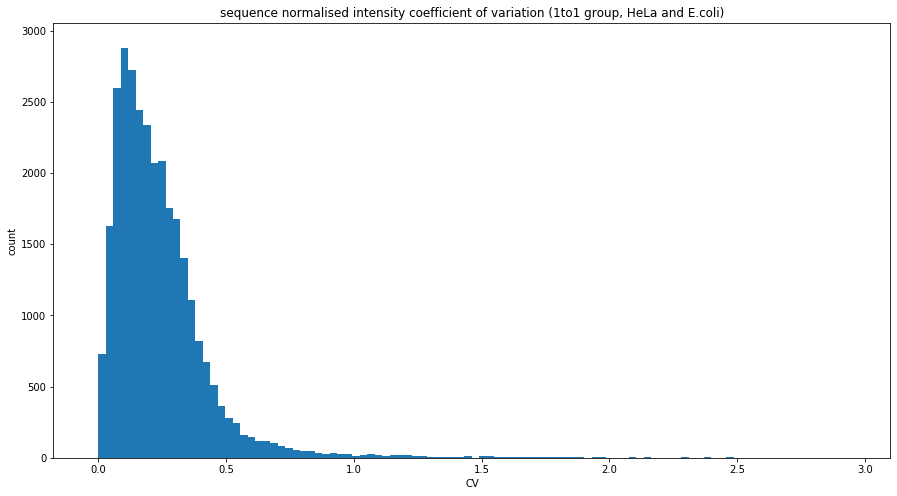

In [63]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)
plt.title('sequence normalised intensity coefficient of variation (1to1 group, HeLa and E.coli)')

bins = 100
hist, bins, _ = plt.hist(sequence_cv_by_batch_df[sequence_cv_by_batch_df.batch == '1to1'].normalised_intensity_cv, bins=bins)
plt.xlabel('CV')
plt.ylabel('count')

plt.show()

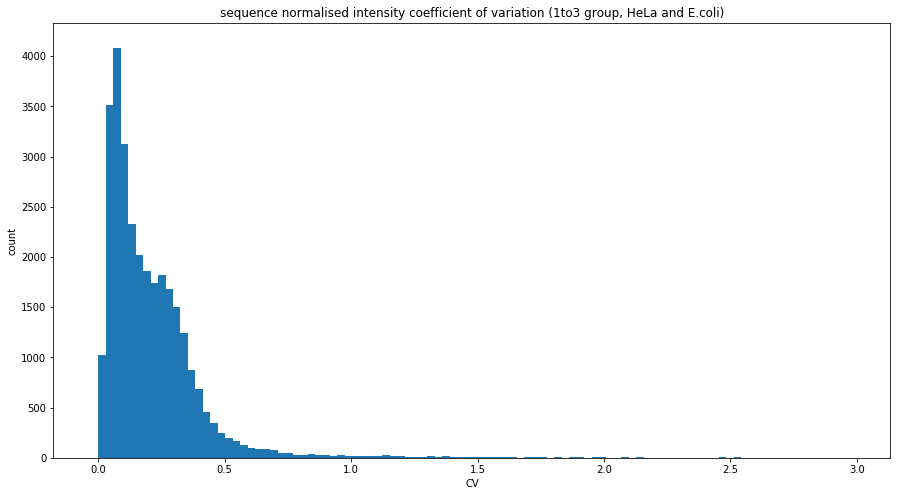

In [64]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)
plt.title('sequence normalised intensity coefficient of variation (1to3 group, HeLa and E.coli)')

bins = 100
hist, bins, _ = plt.hist(sequence_cv_by_batch_df[sequence_cv_by_batch_df.batch == '1to3'].normalised_intensity_cv, bins=bins)
plt.xlabel('CV')
plt.ylabel('count')

plt.show()

#### calculate the experiment mean after normalisation

In [65]:
sequences_df.columns

Index(['sequence', 'charge', 'file_idx', 'intensity_all_points',
       'intensity_saturation_adjusted', 'intensity_top_3', 'monoisotopic_mz',
       'rt_apex', 'scan_apex', 'intensity', 'classed_as', 'run_name', 'batch',
       'human', 'log_intensity', 'experiment_intensity_mean',
       'experiment_intensity_std_dev', 'experiment_rt_mean',
       'experiment_rt_std_dev', 'experiment_scan_mean',
       'experiment_scan_std_dev', 'number_of_runs_for_sequence',
       'delta_intensity', 'estimated_delta_intensity',
       'normalised_intensity_log', 'normalised_intensity_normal'],
      dtype='object')

In [66]:
sequences_df.file_idx.unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19])

In [67]:
# find the experiment-wide intensity mean
experiment_intensities_l = []
for group_name,group_df in sequences_df.groupby(['sequence','charge'], as_index=False):
    mean_normalised_intensity = np.mean(group_df.normalised_intensity_log)
    sequence = group_name[0]
    charge = group_name[1]
    experiment_intensities_l.append((sequence,charge,mean_normalised_intensity))

experiment_intensities_post_normalisation_df = pd.DataFrame(experiment_intensities_l, columns=['sequence','charge','mean_normalised_intensity'])

In [68]:
sequences_df = pd.merge(sequences_df, experiment_intensities_post_normalisation_df, how='left', left_on=['sequence','charge'], right_on=['sequence','charge'])

In [69]:
sequences_df.columns

Index(['sequence', 'charge', 'file_idx', 'intensity_all_points',
       'intensity_saturation_adjusted', 'intensity_top_3', 'monoisotopic_mz',
       'rt_apex', 'scan_apex', 'intensity', 'classed_as', 'run_name', 'batch',
       'human', 'log_intensity', 'experiment_intensity_mean',
       'experiment_intensity_std_dev', 'experiment_rt_mean',
       'experiment_rt_std_dev', 'experiment_scan_mean',
       'experiment_scan_std_dev', 'number_of_runs_for_sequence',
       'delta_intensity', 'estimated_delta_intensity',
       'normalised_intensity_log', 'normalised_intensity_normal',
       'mean_normalised_intensity'],
      dtype='object')

In [70]:
sequences_df['normalised_delta_intensity'] = (sequences_df.normalised_intensity_log - sequences_df.experiment_intensity_mean) / sequences_df.experiment_intensity_mean


In [71]:
sequences_df.columns

Index(['sequence', 'charge', 'file_idx', 'intensity_all_points',
       'intensity_saturation_adjusted', 'intensity_top_3', 'monoisotopic_mz',
       'rt_apex', 'scan_apex', 'intensity', 'classed_as', 'run_name', 'batch',
       'human', 'log_intensity', 'experiment_intensity_mean',
       'experiment_intensity_std_dev', 'experiment_rt_mean',
       'experiment_rt_std_dev', 'experiment_scan_mean',
       'experiment_scan_std_dev', 'number_of_runs_for_sequence',
       'delta_intensity', 'estimated_delta_intensity',
       'normalised_intensity_log', 'normalised_intensity_normal',
       'mean_normalised_intensity', 'normalised_delta_intensity'],
      dtype='object')

#### plot the variation of delta intensity with RT

In [72]:
file_idx = 2
run_name = run_name_for_file_idx(file_idx)
run_name

'190719_Hela_Ecoli_1to1_09'

In [73]:
df = sequences_df.copy()
df = df[df.file_idx == file_idx]

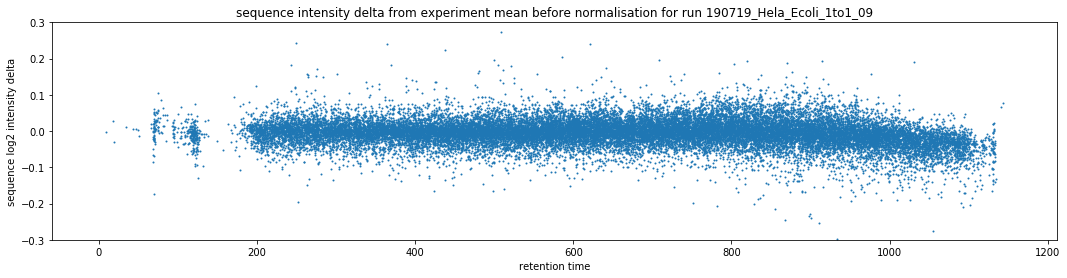

In [90]:
f, ax = plt.subplots()
f.set_figheight(4)
f.set_figwidth(18)

plt.margins(0.06)
plt.title('sequence intensity delta from experiment mean before normalisation for run {}'.format(run_name))

ax.scatter(df.rt_apex, df.delta_intensity, marker='o', lw=0, s=4, alpha=1.0)

plt.ylabel('sequence log2 intensity delta')
plt.xlabel('retention time')
# plt.xlim((300,400))
plt.ylim((-0.3,+0.3))

plt.show()

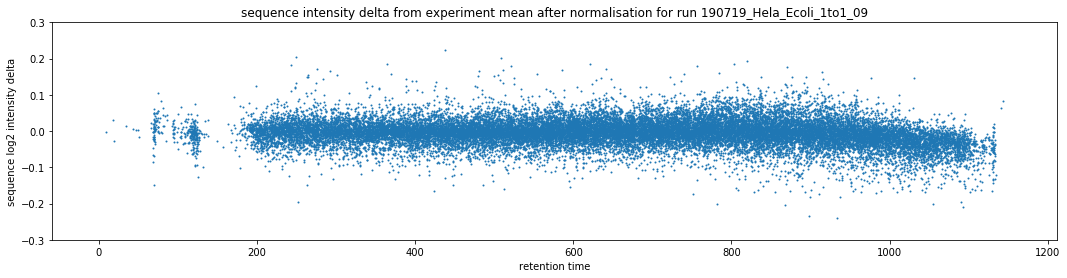

In [91]:
f, ax = plt.subplots()
f.set_figheight(4)
f.set_figwidth(18)

plt.margins(0.06)
plt.title('sequence intensity delta from experiment mean after normalisation for run {}'.format(run_name))

ax.scatter(df.rt_apex, df.estimated_delta_intensity, marker='o', lw=0, s=4, alpha=1.0)

plt.ylabel('sequence log2 intensity delta')
plt.xlabel('retention time')
# plt.xlim((300,400))
plt.ylim((-0.3,+0.3))

plt.show()